In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow import keras
from keras.metrics import Recall
from functools import partial
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, ShuffleSplit, cross_val_score, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from scikeras.wrappers import KerasClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
plt.rcParams['figure.figsize'] = (15,10)
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['axes.labelsize'] = 15

<h1> Data Cleaning and Prepocessing </h1>
Dataset: about customers of a bank.
<br>
Objective: understand if a customer will exit the bank circuit in a given period of time.

In [2]:
data = pd.read_csv('Churn_Modelling.csv')
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [3]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Of course dirst tree columns won't be of any help, let's drop it.
<br>
We can see that the dataset is already clean, we just need to encode the categorical variables.

In [4]:
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1, inplace = True)
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [5]:
data.columns = data.columns.str.lower()
data.geography.unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [6]:
encoder = LabelEncoder()
data['gender'] = encoder.fit_transform(data.gender)
data['geography'] = encoder.fit_transform(data.geography)

Now data is encoded, let's split data and see the features distribution

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.iloc[:,-1], test_size = 0.15)


In [8]:
X_train.describe()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary
count,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000
mean,650.896118,0.750235,0.547882,38.941882,5.030353,76372.039742,1.526824,0.705882,0.510353,99830.352176
std,95.872622,0.829418,0.497731,10.480083,2.891133,62353.277357,0.579982,0.455672,0.499922,57593.713515
min,350.000000,0.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000
25%,584.000000,0.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,50691.817500
50%,652.000000,0.500000,1.000000,37.000000,5.000000,97245.995000,1.000000,1.000000,1.000000,99496.600000
75%,717.000000,2.000000,1.000000,44.000000,8.000000,127568.777500,2.000000,1.000000,1.000000,149373.527500
max,850.000000,2.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000


<AxesSubplot:xlabel='exited', ylabel='Count'>

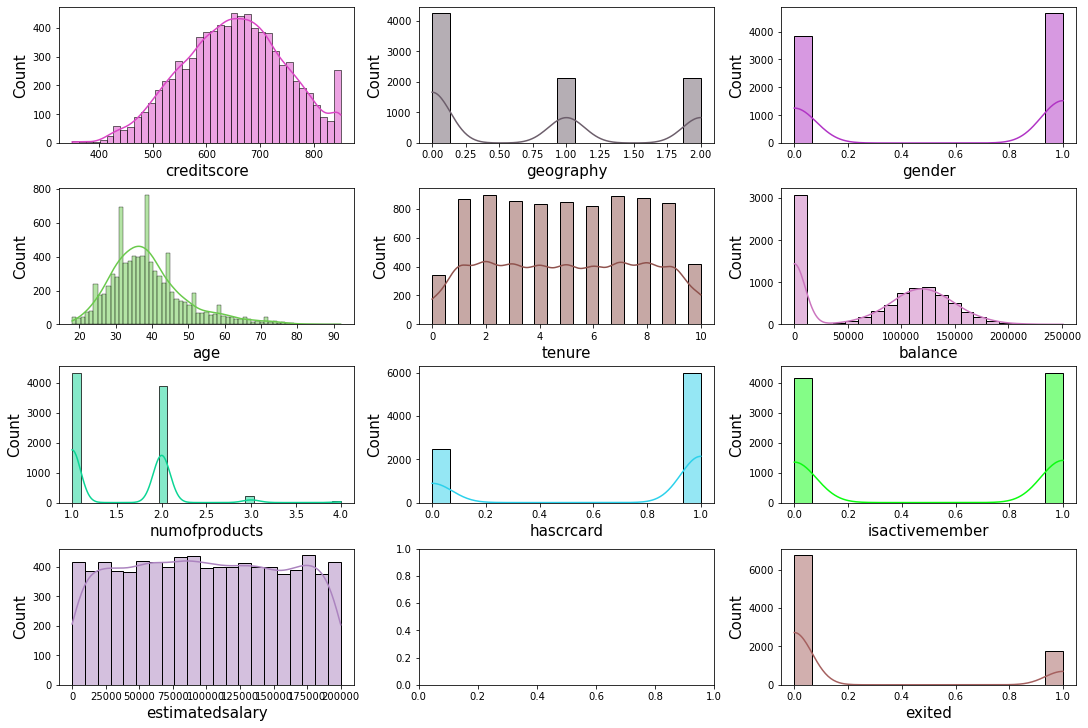

In [9]:
fig, axes = plt.subplots(4,3)
for col, ax in zip(X_train.columns, axes.flatten()):
    sns.histplot(X_train[col], kde = True, color = np.random.random(3), ax = ax)

sns.histplot(y_train, kde = True, color = np.random.random(3), ax = axes.flatten()[-1])

We can see that classes are unbalanced and that there aren't outliers, except for 'balance'
<br>
Now we see if there is a correlation betwwen features 

<AxesSubplot:>

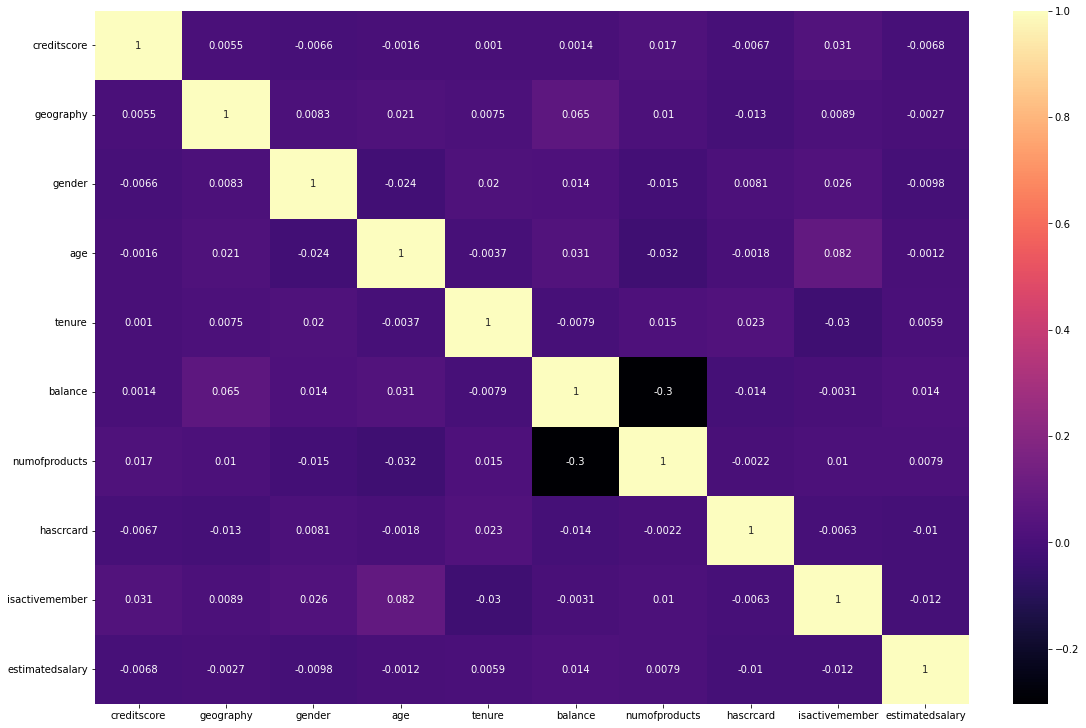

In [10]:
corr = X_train.corr()
sns.heatmap(corr, annot=True, cmap = 'magma')

Great! Features are not correlated
<br>
Now let's scale the data and define our model

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<h1> Neural Network </h1>

In [12]:
def ann():
    RegularizedDense = partial(keras.layers.Dense,
                               activation="elu",
                               kernel_initializer="he_normal",
                               #kernel_regularizer=keras.regularizers.l2(0.001)
                              )

    ann = keras.models.Sequential([
        keras.layers.InputLayer(input_shape = [X_train_scaled.shape[1]]),
        RegularizedDense(10),
        RegularizedDense(10),
        keras.layers.Dense(1, activation = 'sigmoid')])

    ann.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return ann

Let's wrap the neural network so we ca use cross validation in scikit learn 

In [13]:
callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience = 50)
ann_wrap = KerasClassifier(ann(), epochs = 100,  batch_size = 32, verbose=True, callbacks = [callback])
cv = ShuffleSplit(n_splits=15, test_size=0.15) 
scores = cross_val_score(ann_wrap, X_train_scaled, y_train, cv=cv, n_jobs=-1)

INFO:tensorflow:Assets written to: C:\Users\ggiam\AppData\Local\Temp\tmptsx3d4cz\assets
INFO:tensorflow:Assets written to: C:\Users\ggiam\AppData\Local\Temp\tmpzubxw20s\assets
INFO:tensorflow:Assets written to: C:\Users\ggiam\AppData\Local\Temp\tmpr9z5f9hv\assets
INFO:tensorflow:Assets written to: C:\Users\ggiam\AppData\Local\Temp\tmpio4imile\assets
INFO:tensorflow:Assets written to: C:\Users\ggiam\AppData\Local\Temp\tmpv2xl25i5\assets
INFO:tensorflow:Assets written to: C:\Users\ggiam\AppData\Local\Temp\tmp_26nqj58\assets
INFO:tensorflow:Assets written to: C:\Users\ggiam\AppData\Local\Temp\tmpq7oaxxrv\assets
INFO:tensorflow:Assets written to: C:\Users\ggiam\AppData\Local\Temp\tmpbmgox7d0\assets
INFO:tensorflow:Assets written to: C:\Users\ggiam\AppData\Local\Temp\tmpnl8rp77_\assets
INFO:tensorflow:Assets written to: C:\Users\ggiam\AppData\Local\Temp\tmpewo22n55\assets
INFO:tensorflow:Assets written to: C:\Users\ggiam\AppData\Local\Temp\tmp_dzia106\assets
INFO:tensorflow:Assets written t

In [14]:
scores.mean()

0.8621699346405229

Mean validation score over 6 splits is 0.862, not bad, now let's see the learning curves

In [15]:
df_size = [i/10 for i in range(1,11)]
ann_wrap = KerasClassifier(ann(), epochs = 100,  batch_size = 32, verbose=True, callbacks = [callback])

data_size, train_score, valid_score = learning_curve(ann_wrap,
                                                     X_train_scaled, y_train,
                                                     train_sizes=df_size,
                                                     n_jobs=-1, cv = 5
                                                    )

INFO:tensorflow:Assets written to: C:\Users\ggiam\AppData\Local\Temp\tmpa60l7f2m\assets
INFO:tensorflow:Assets written to: C:\Users\ggiam\AppData\Local\Temp\tmp49z42izn\assets
INFO:tensorflow:Assets written to: C:\Users\ggiam\AppData\Local\Temp\tmpbhpwwd6_\assets
INFO:tensorflow:Assets written to: C:\Users\ggiam\AppData\Local\Temp\tmp0uzlj9n1\assets
INFO:tensorflow:Assets written to: C:\Users\ggiam\AppData\Local\Temp\tmplrte05sg\assets
INFO:tensorflow:Assets written to: C:\Users\ggiam\AppData\Local\Temp\tmpp8araw4v\assets
INFO:tensorflow:Assets written to: C:\Users\ggiam\AppData\Local\Temp\tmp6zqw0ux7\assets
INFO:tensorflow:Assets written to: C:\Users\ggiam\AppData\Local\Temp\tmpd9pjzb5z\assets
INFO:tensorflow:Assets written to: C:\Users\ggiam\AppData\Local\Temp\tmpus6hossi\assets
INFO:tensorflow:Assets written to: C:\Users\ggiam\AppData\Local\Temp\tmpy94g2xa5\assets
INFO:tensorflow:Assets written to: C:\Users\ggiam\AppData\Local\Temp\tmpvzws31bu\assets
INFO:tensorflow:Assets written t

In [16]:
#Function to plot standard deviation of learning curves
def plot_curves(data_size, train_score, valid_score, ax):
    
    train_mean = train_score.mean(axis = 1)
    valid_mean = valid_score.mean(axis = 1)
    upper_train = train_mean + train_score.std(axis = 1)
    upper_valid = valid_mean + valid_score.std(axis = 1)
    lower_train = train_mean - train_score.std(axis = 1)
    lower_valid = valid_mean - valid_score.std(axis = 1)

    sns.lineplot(x=data_size, y = train_mean, label = 'train score', ax = ax)
    sns.lineplot(x=data_size, y = valid_mean, label = 'valid score', ax = ax)
    ax.fill_between(data_size, lower_train, upper_train, alpha=.2)
    ax.fill_between(data_size, lower_valid, upper_valid, alpha=.2)
    ax.grid()
    ax.set_xlabel('data size')
    ax.set_ylabel('$F_1$ score')
    
    return ax

<AxesSubplot:xlabel='data size', ylabel='$F_1$ score'>

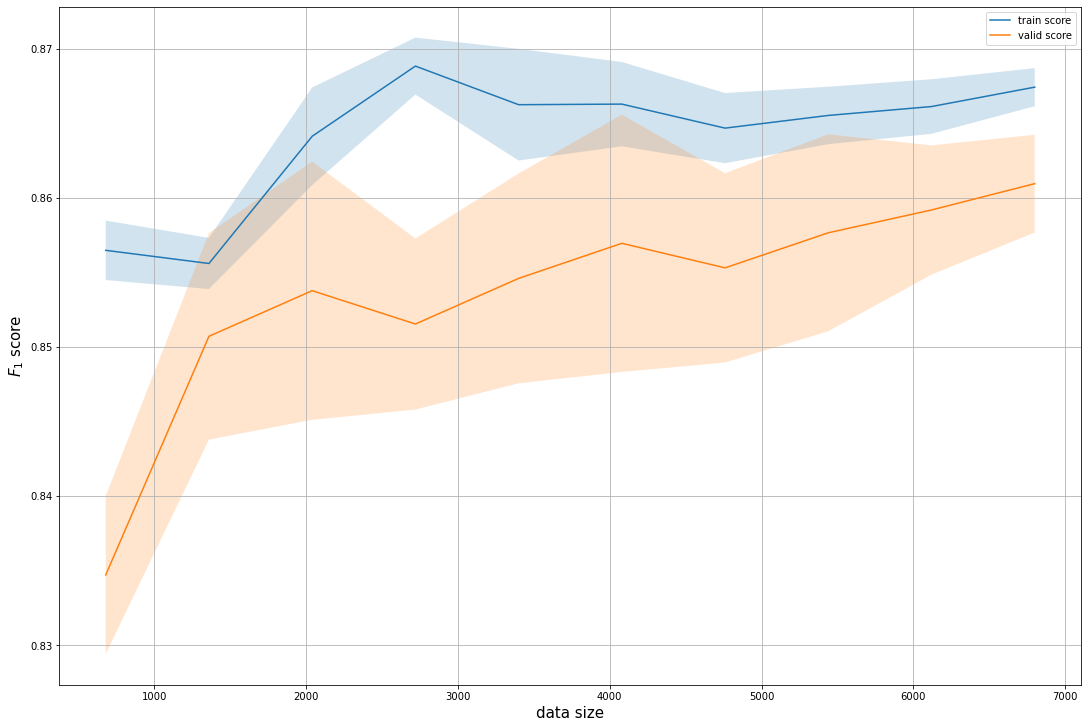

In [17]:
fig, ax = plt.subplots()
plot_curves(data_size, train_score, valid_score, ax)

The model isn't overfitting but there could be margin of improvement
<br>
In the end let's evaluate the model on test set

In [18]:
ann_wrap = KerasClassifier(ann(), epochs = 100, batch_size = 32, verbose=1, callbacks = [callback])
ann_wrap.fit(X_train_scaled, y_train)
ann_wrap.score(X_test_scaled, y_test)

Epoch 1/100
266/266 [==============================] - 1s 1ms/step - loss: 0.6572 - accuracy: 0.6526
Epoch 2/100
266/266 [==============================] - 0s 1ms/step - loss: 0.4407 - accuracy: 0.8108
Epoch 3/100
266/266 [==============================] - 0s 1ms/step - loss: 0.4185 - accuracy: 0.8226
Epoch 4/100
266/266 [==============================] - 0s 967us/step - loss: 0.4065 - accuracy: 0.8292
Epoch 5/100
266/266 [==============================] - 0s 1ms/step - loss: 0.3949 - accuracy: 0.8362
Epoch 6/100
266/266 [==============================] - 0s 999us/step - loss: 0.3829 - accuracy: 0.8406
Epoch 7/100
266/266 [==============================] - 0s 890us/step - loss: 0.3731 - accuracy: 0.8474
Epoch 8/100
266/266 [==============================] - 0s 714us/step - loss: 0.3661 - accuracy: 0.8484
Epoch 9/100
266/266 [==============================] - 0s 860us/step - loss: 0.3608 - accuracy: 0.8526
Epoch 10/100
266/266 [==============================] - 0s 1ms/step - loss: 0.356

0.852

Great! we achieved a score of 0.852, the model can generalize quite good

Now let's see the confusion matrix

47/47 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1201
           1       0.72      0.42      0.53       299

    accuracy                           0.85      1500
   macro avg       0.80      0.69      0.72      1500
weighted avg       0.84      0.85      0.84      1500



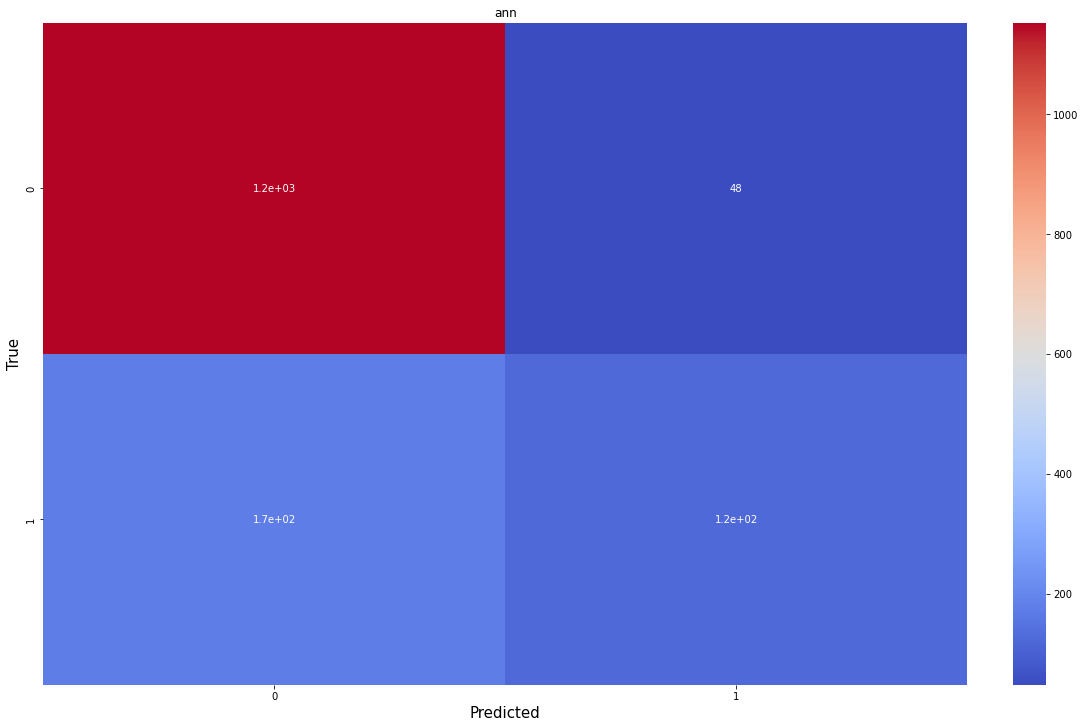

In [19]:
pred = ann_wrap.predict(X_test_scaled)
cm = confusion_matrix(y_test, pred)
sns.heatmap(cm ,annot = True, cmap = 'coolwarm' )
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('ann')
print(classification_report(y_true=y_test, y_pred = pred))

We missmatched a lot of people who left the circuit, in this case would be better to try with another model.

Unfortunately we can't optimize the recall 

Just for comparison let's try a Gridsearch over a random forest algorithm

In [20]:
params = {'max_depth':[i for i in range(9, 15)],
          'n_estimators':[i*10 for i in range(15, 20)]
         }

rf= RandomForestClassifier()
grid = GridSearchCV(rf, param_grid=params, scoring = 'accuracy', cv = cv, n_jobs=-1)
grid.fit(X_train_scaled, y_train)
best = grid.best_estimator_
print(grid.best_params_)

{'max_depth': 13, 'n_estimators': 150}


              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1201
           1       0.76      0.42      0.55       299

    accuracy                           0.86      1500
   macro avg       0.82      0.70      0.73      1500
weighted avg       0.85      0.86      0.84      1500



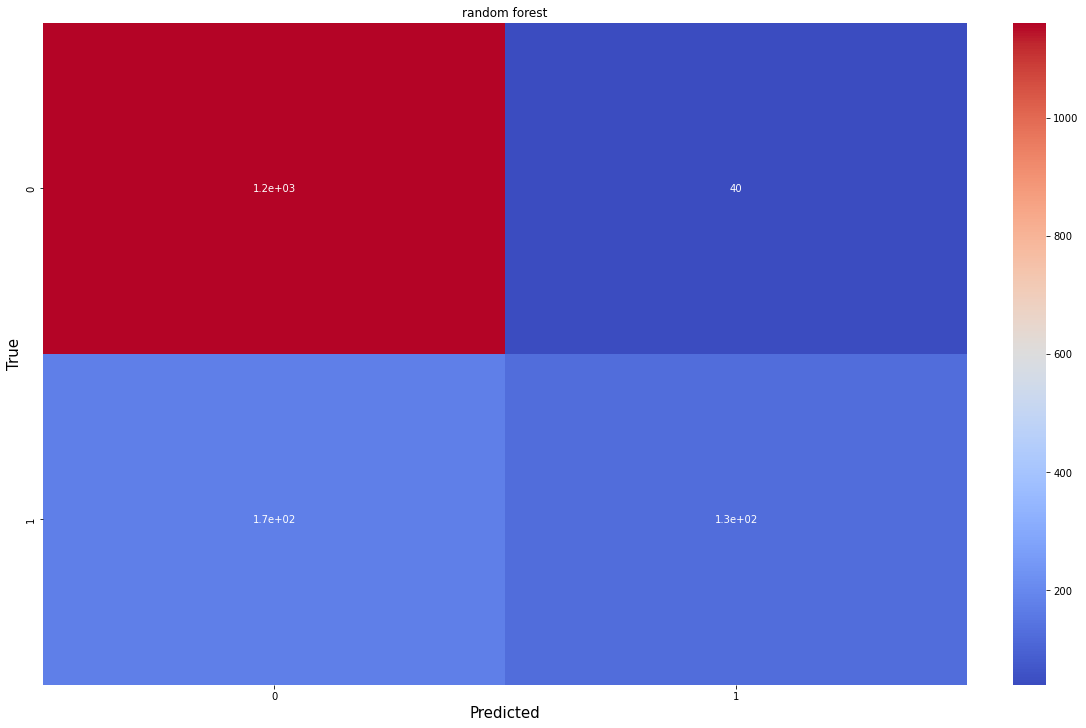

In [21]:
rf_pred = best.predict(X_test_scaled)
cm = confusion_matrix(y_true=y_test, y_pred= rf_pred)
sns.heatmap(cm ,annot = True, cmap = 'coolwarm' )
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('random forest')
print(classification_report(y_true=y_test, y_pred = rf_pred))

The model performs like the ann.

Probably using these models everyone would be classified as a quitter and won't be helped with a loan